# Stock Price Forecasting using Linear Regression

In this notebook, I am exploring the use of linear regression for stock price forecasting. The workflow involves fetching historical stock data, creating features, training a linear regression model, and evaluating its performance. Visualizations are included to compare actual and predicted stock prices.

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2020-01-02  72.716072  72.776598  71.466812  71.721019  135480400
2020-01-03  72.009117  72.771745  71.783962  71.941328  146322800
2020-01-06  72.582901  72.621639  70.876068  71.127858  118387200
2020-01-07  72.241554  72.849231  72.021238  72.592601  108872000
2020-01-08  73.403656  73.706287  71.943766  71.943766  132079200


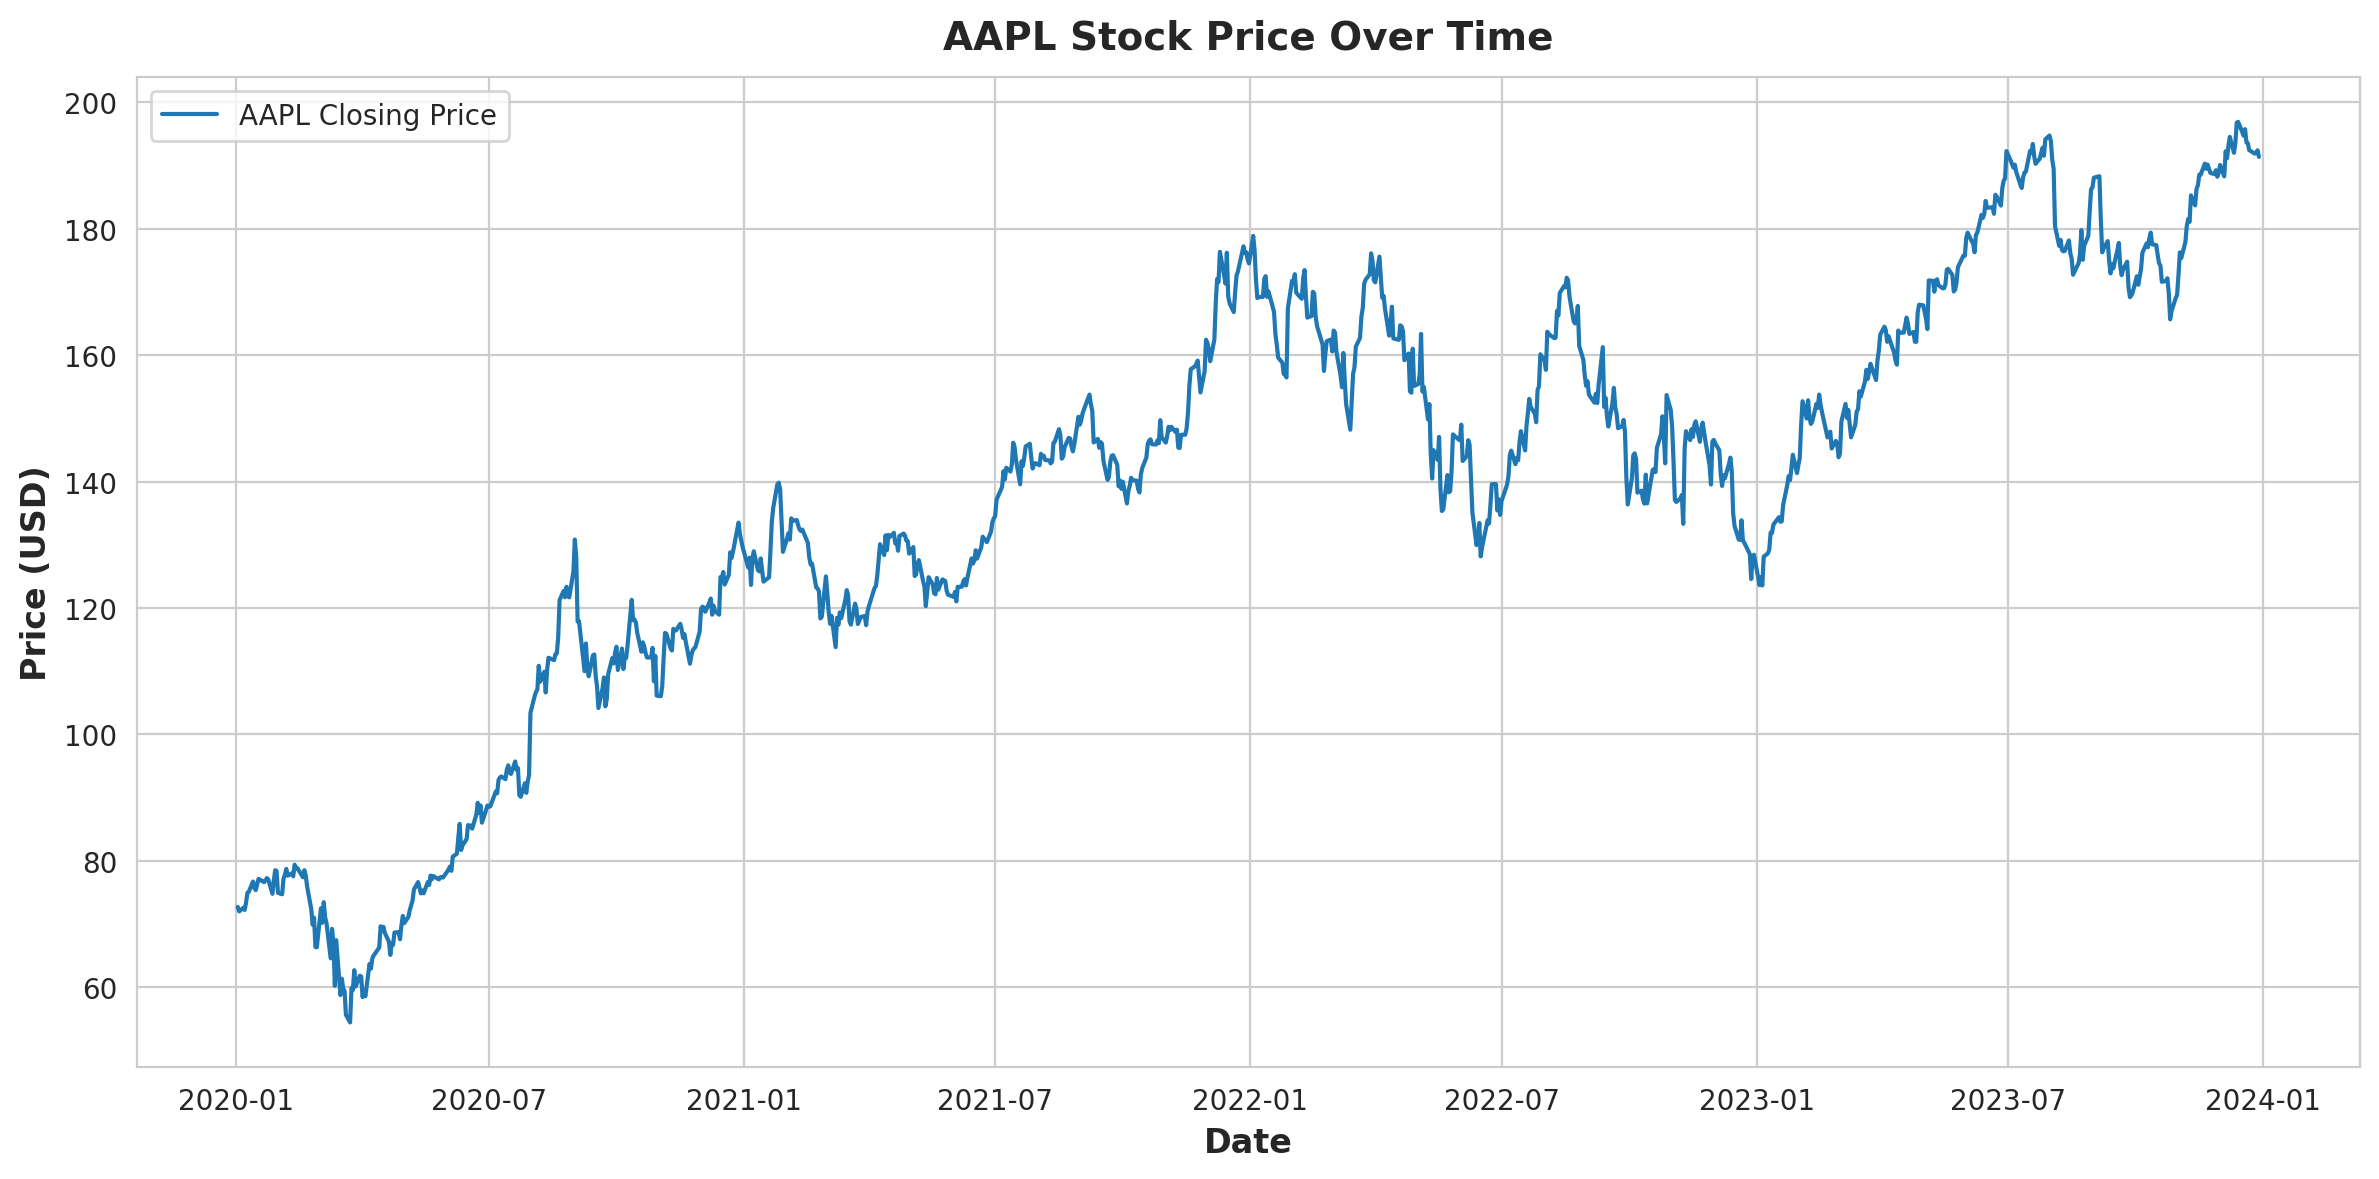

In [1]:
import yfinance as yf  # yahoo finance for historical stock data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set_style("whitegrid")

# Set Matplotlib defaults
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

# Define the stock and time period
ticker = "AAPL"  # Change to any stock symbol you like
start_date = "2020-01-01"
end_date = "2024-01-01"

# Fetch data
data = yf.download(ticker, start=start_date, end=end_date)

# Quick check
print(data.head())

# Plot stock prices over time; closing price
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label=f"{ticker} Closing Price")
plt.title(f"{ticker} Stock Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.legend()
plt.show()

Try a simple linear regression model with only feature the time dummy. Let's call $y_t$ the prediction and $t$ the time dummy (a label for time instances). The model assumes the data are described by
$$y_t = b_0 + b_1 \, t + \epsilon_t \,,$$
where $b_0$ is the intercection (bias), $b_1$ the weight, and $\epsilon_t$ some error that is not accounted for in the linear fit (trend). 

We train the model on the first 80% of data and forecast the next 20%.

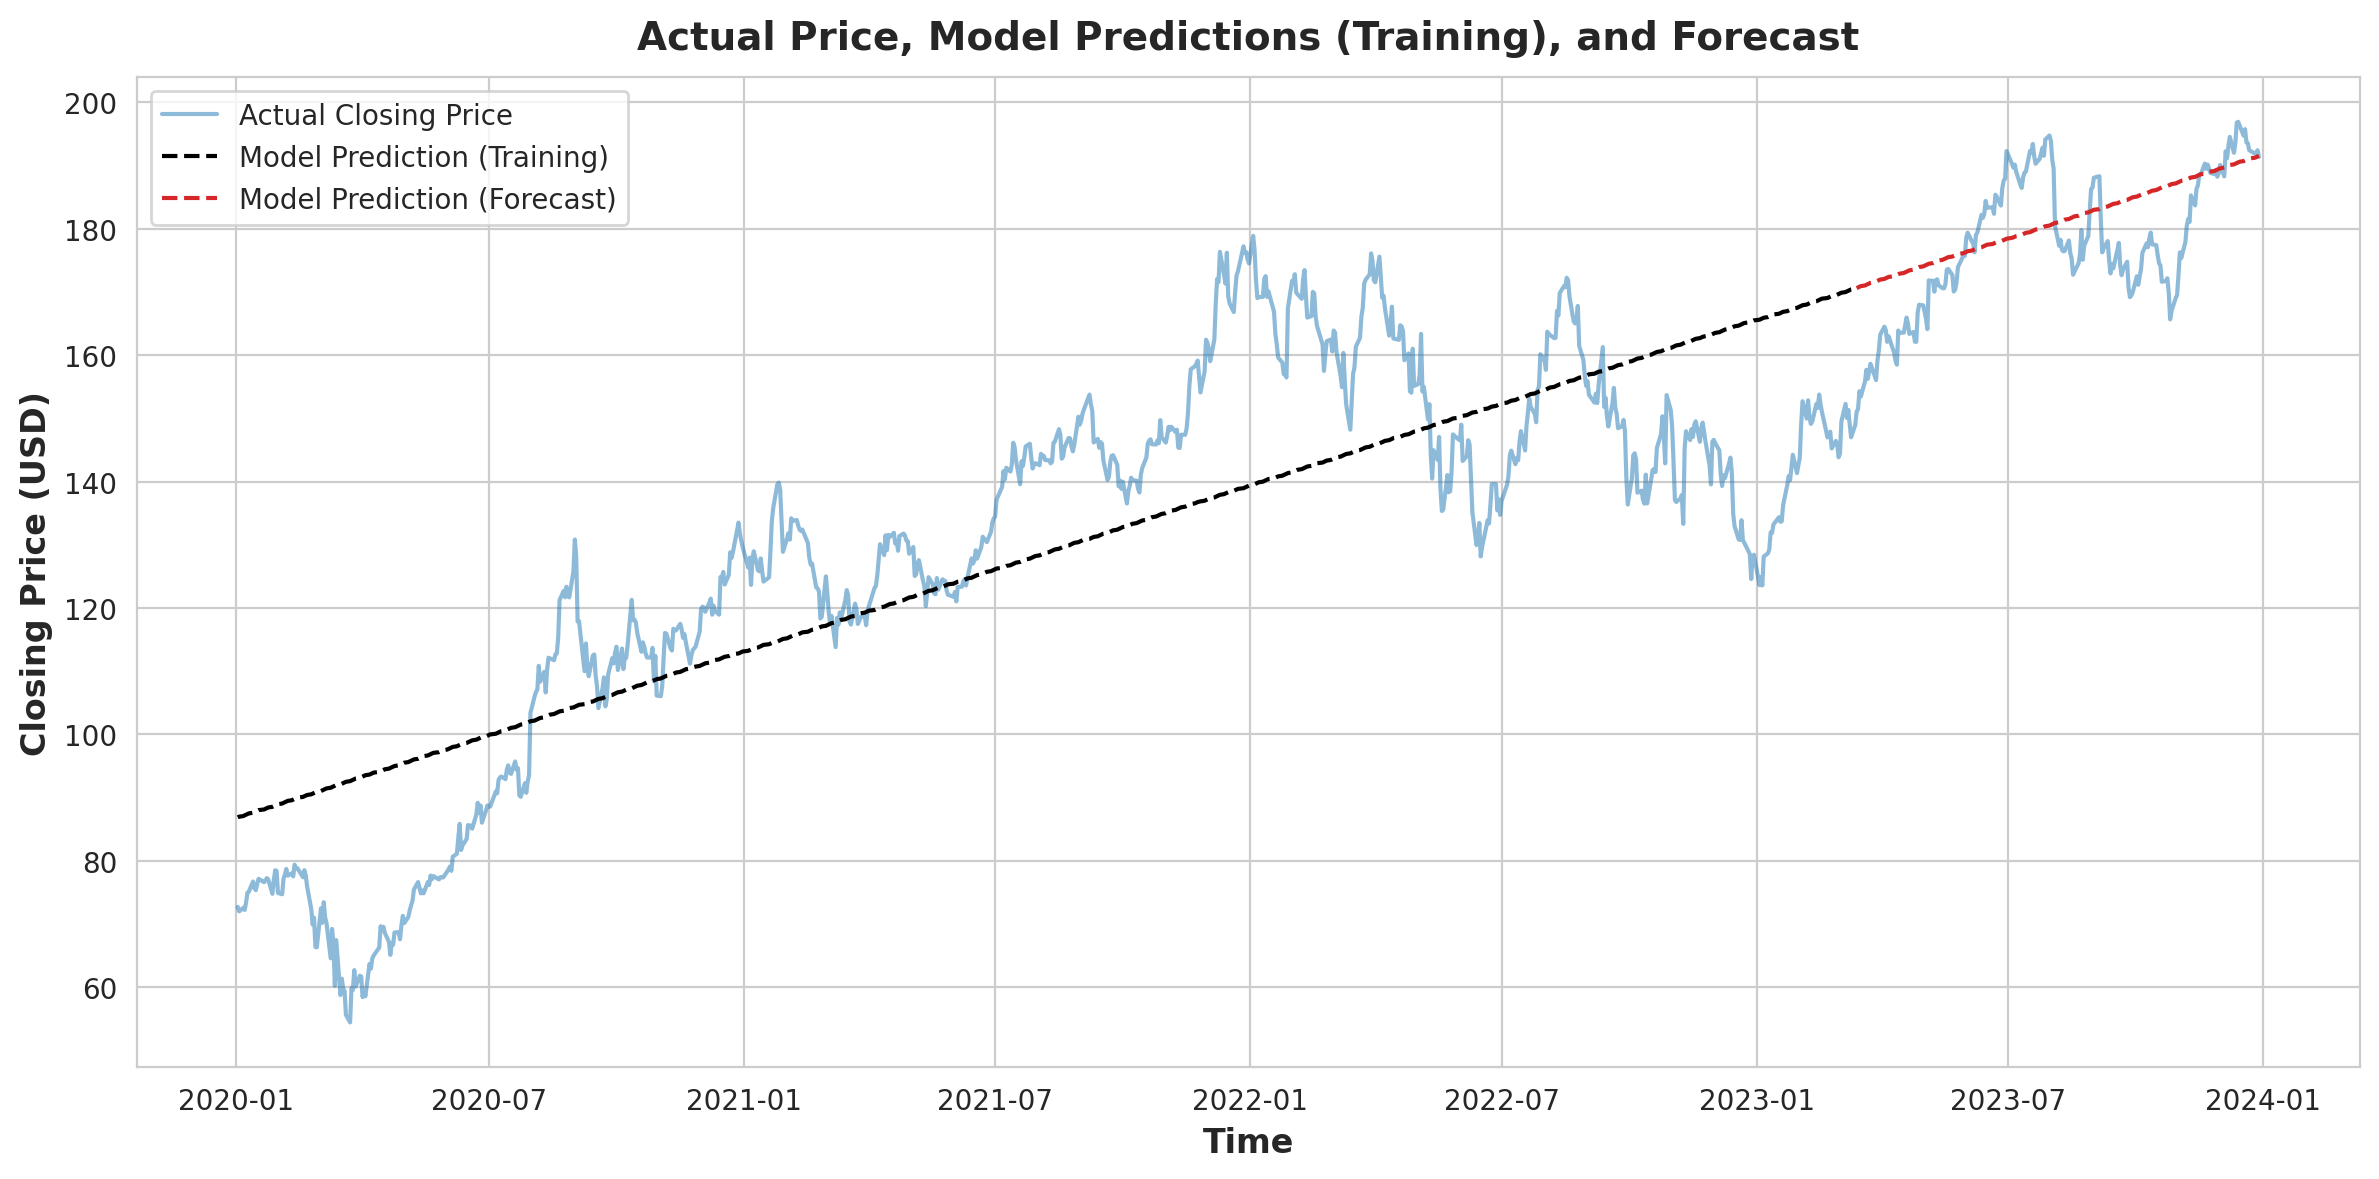

Model evaluation on the test set:
Mean Squared Error (Test): 83.14
Mean Absolute Error (Test): 7.68


In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Ensure `data` is a DataFrame
df = data.copy()

# Create a time dummy (labels for each time point)
time = np.arange(len(df.index))  # Create a sequence of integers for the time index
df['time'] = time

# Create features and target
X = df[['time']]  # Features (time dummy)
y = df['Close']   # Target (closing price)

# Train-test split (80% train, 20% test, no shuffling to preserve time order)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_train_pred = pd.Series(model.predict(X_train).flatten(), index=X_train.index)  # Predictions for training set
y_test_pred = pd.Series(model.predict(X_test).flatten(), index=X_test.index)    # Predictions for testing set

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))

# Plot the actual closing price
plt.plot(df.index, df['Close'], label="Actual Closing Price", color="tab:blue", alpha=0.5)

# Plot the model's predictions on the training set
plt.plot(X_train.index, y_train_pred, label="Model Prediction (Training)", color="black", linestyle="--")

# Plot the model's predictions on the test set (forecast)
plt.plot(X_test.index, y_test_pred, label="Model Prediction (Forecast)", color="tab:red", linestyle="--")

# Add labels, title, and legend
plt.title("Actual Price, Model Predictions (Training), and Forecast")
plt.xlabel("Time")
plt.ylabel("Closing Price (USD)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Evaluate the model on the test set
print("Model evaluation on the test set:")
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
print(f"Mean Squared Error (Test): {mse:.2f}")
print(f"Mean Absolute Error (Test): {mae:.2f}")

Next, try to make the fit more complex by adding Fourier features, which is pairs of $\sin(2\pi k f t)$ and $\cos(2\pi k f t)$, where $k$ is the order and $f$ their period (the higher the order $k$ the more zero-crossings they have within their period $f$). The model now fits the following curve to the data:

$$y_t = b_0 + b_1 t + \sum_{i=1}^{k} \left[ \alpha_i \sin(2 \pi k f t) + \beta_i \cos(2 \pi k f t) \right]\,,$$
where $\alpha_i$ and $\beta_i$ are the weights for each Fourier feature. We assume that the period $f$ is annual here. We experiment with different orders $k$.

/home/thanasis/anaconda3/envs/market_forecasting_ml_py3.10/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)


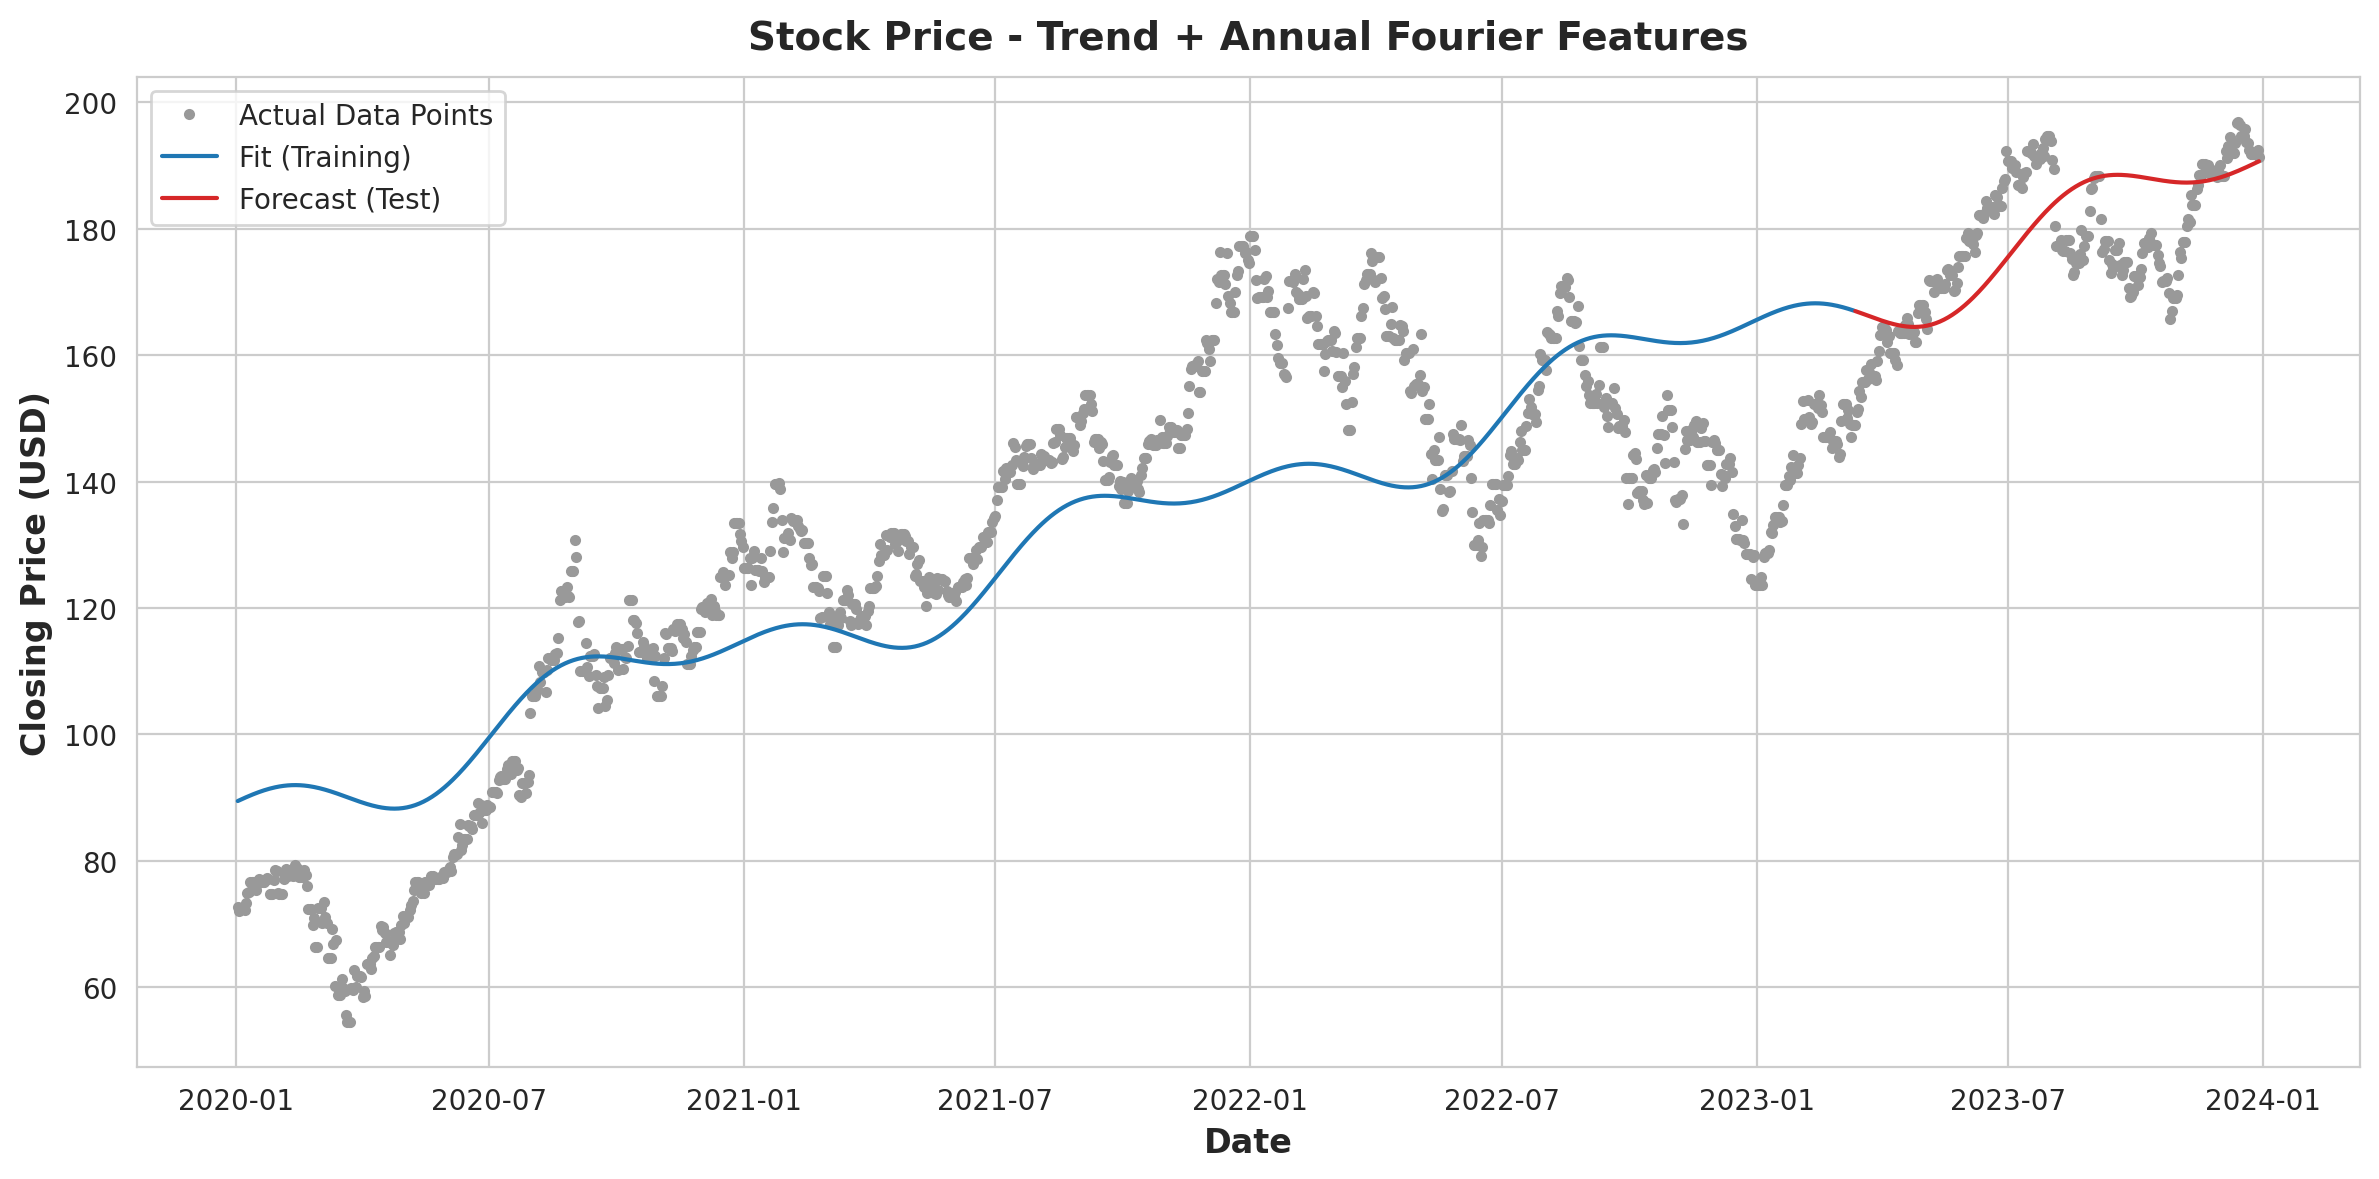

Model evaluation on the test set:
Mean Squared Error (Test): 92.51
Mean Absolute Error (Test): 8.19


In [3]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

# Ensure the index is a DatetimeIndex with a frequency
data.index = pd.to_datetime(data.index)  # Ensure the index is datetime
data = data.asfreq('D')  # Set the frequency to daily ('D')

# Fill missing values in the 'Close' column
data['Close'] = data['Close'].bfill()  # Backward-fill missing values (copies next-in-time value to missing value)

# Define Fourier terms for annual seasonality
fourier = CalendarFourier(freq="A", order=2)  # #order sin/cos pairs for annual seasonality

# Create the DeterministicProcess
dp = DeterministicProcess(
    index=data.index,
    constant=True,               # Add a constant (bias term)
    order=1,                     # Linear trend
    seasonal=False,               # Weekly seasonality
    additional_terms=[fourier],  # Annual seasonality (Fourier terms)
    drop=True,                   # Drop collinear terms
)

# Generate features for the entire dataset
X = dp.in_sample()
y = data['Close']  # Target variable (closing price)

# Train-test split (80% train, 20% test, no shuffling to preserve time order)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train the model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Generate predictions for the training set
y_train_pred = pd.Series(model.predict(X_train).flatten(), index=X_train.index)

# Generate predictions for the test set
y_test_pred = pd.Series(model.predict(X_test).flatten(), index=X_test.index)

# Plot the results
plt.figure(figsize=(12, 6))

# Plot the actual data points
plt.plot(data.index, data['Close'], '.', color='0.6', label="Actual Data Points")

# Plot the training fit
plt.plot(y_train_pred.index, y_train_pred, label="Fit (Training)", color="C0")

# Plot the forecast for the test set
plt.plot(y_test_pred.index, y_test_pred, label="Forecast (Test)", color="C3")

# Add labels, title, and legend
plt.title("Stock Price - Trend + Annual Fourier Features")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Evaluate the model on the test set
print("Model evaluation on the test set:")
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
print(f"Mean Squared Error (Test): {mse:.2f}")
print(f"Mean Absolute Error (Test): {mae:.2f}")

We see that the model with Fourier features performs worst than the simple linear one, with its performance getting poorer for increasing order $k$. We need to find better features for the model (predictors).

We can try a multiple linear regression model with say $n$ predictors. Then the assumption is that the $y_t$ is described by the relation
$$
y_t = b_0 + \sum_{i=1}^n b_i x_i
\,, 
$$
where $x_i$ are the different predictors. Earlier, we used only $x_1 = t$, that is the time dummy index as a predictor, and we saw the trend. We want to enhance the model with more predictors, and for this we'll explore predictors that have information form past behavior of the timeseries (serial dependence of the signal).

This is why look at autocorrelation and lag plots next.

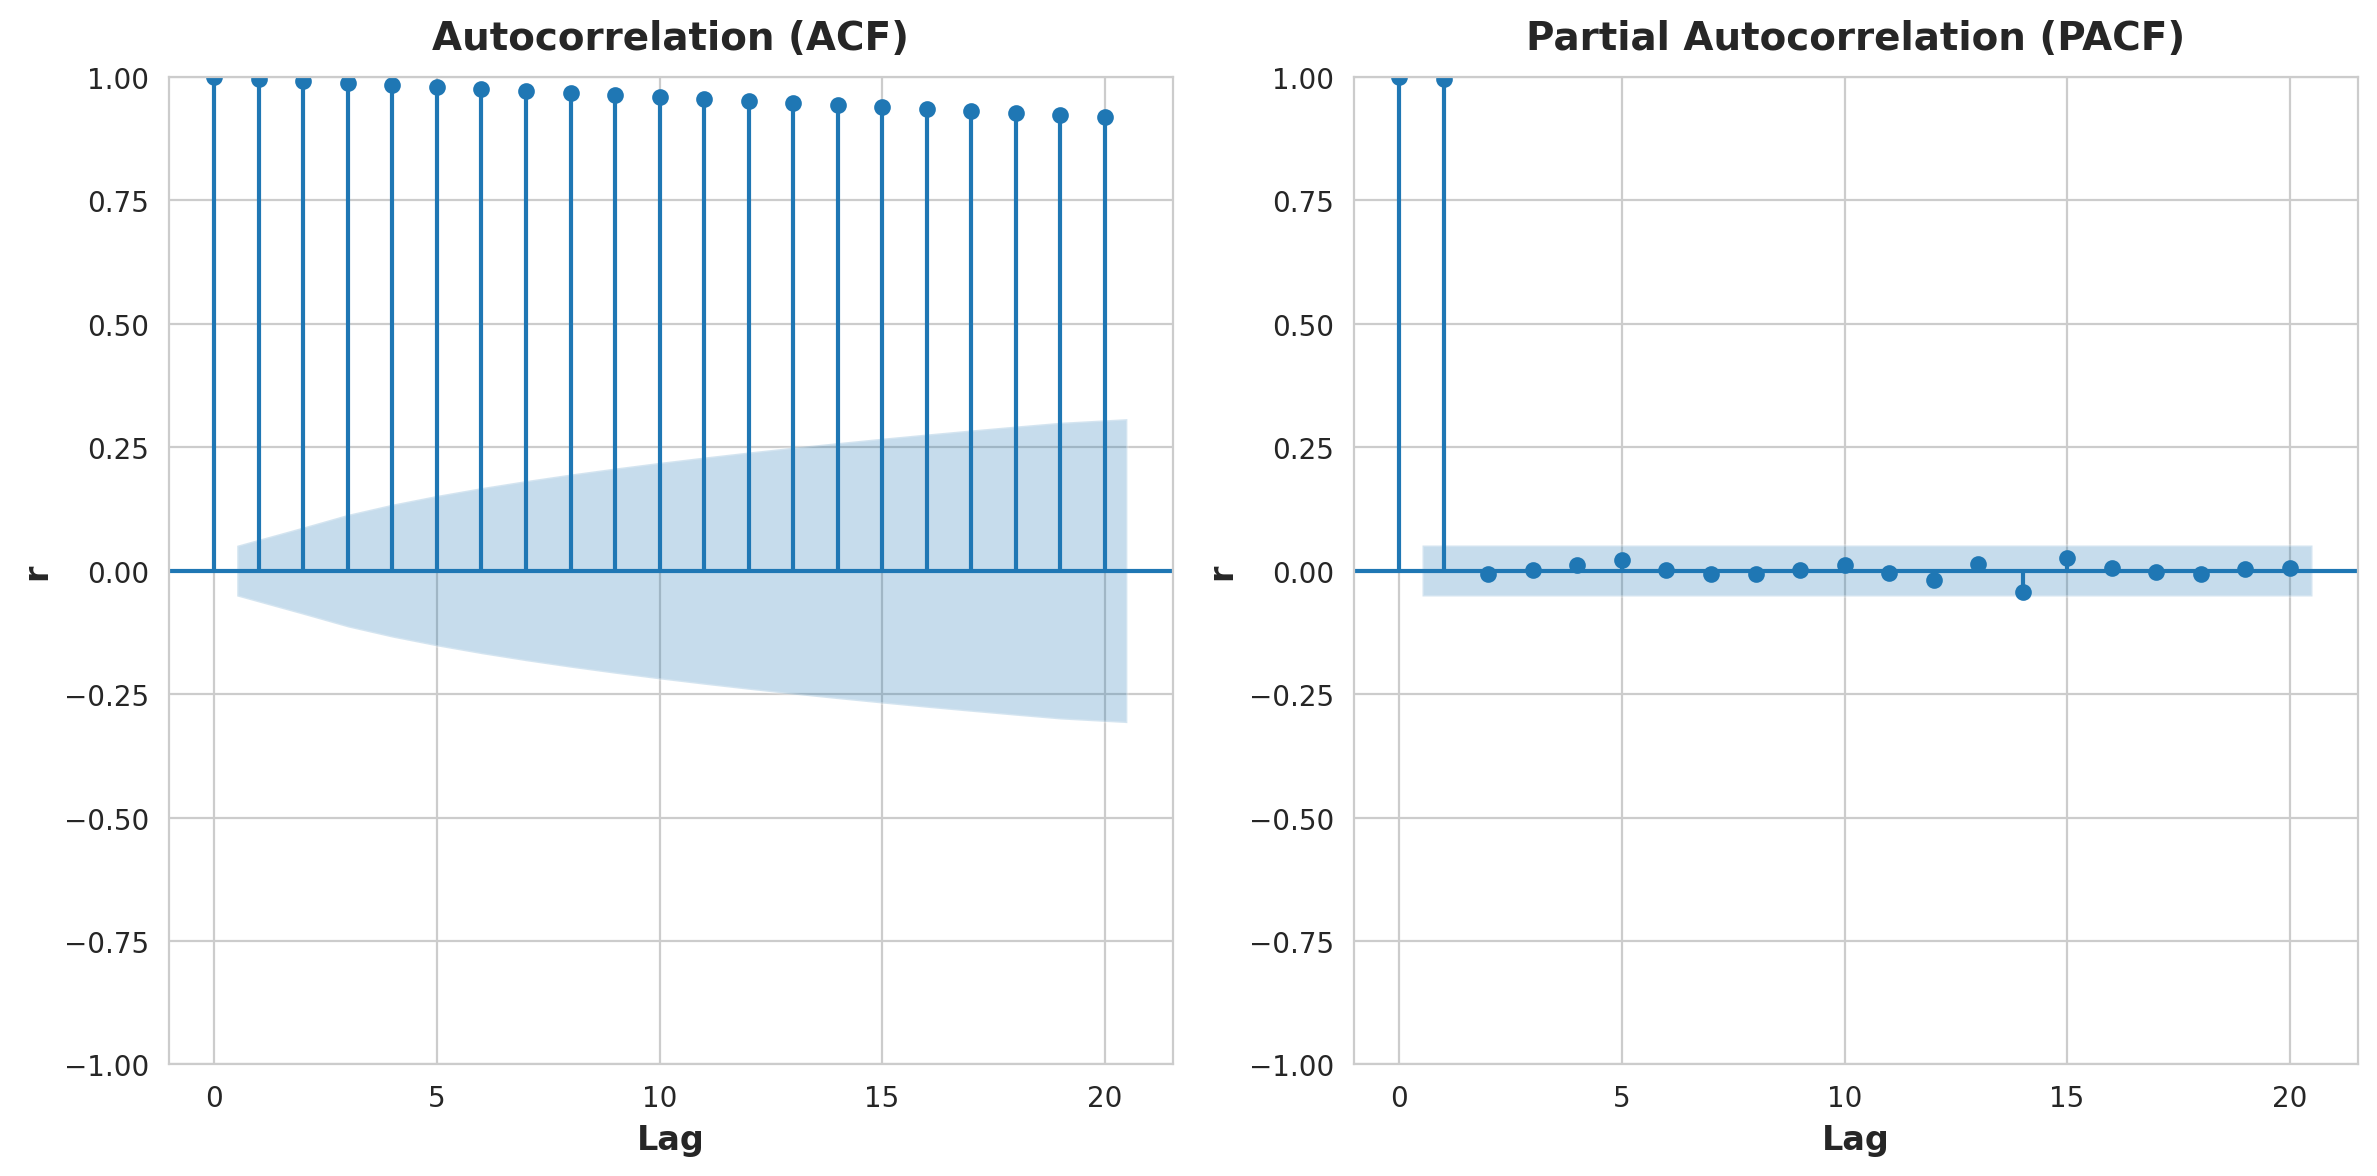

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming `data['Close']` contains the time series data
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with 1 row and 2 columns

# Autocorrelation plot
plot_acf(data['Close'], lags=20, alpha=0.05, ax=axes[0])  # Pass the first subplot axis
axes[0].set_title("Autocorrelation (ACF)")
axes[0].set_xlabel("Lag")
axes[0].set_ylabel("r")

# Partial autocorrelation plot
plot_pacf(data['Close'], lags=20, alpha=0.05, method='ywm', ax=axes[1])  # Pass the second subplot axis
axes[1].set_title("Partial Autocorrelation (PACF)")
axes[1].set_xlabel("Lag")
axes[1].set_ylabel("r")

# Adjust layout
fig.tight_layout()
plt.show()

Let's create the lag data and the lag scatter plots next.

In [5]:
# reload the data
data = yf.download(ticker, start=start_date, end=end_date)
# Ensure y is a 1D Pandas Series
y = data['Close'].squeeze()
# Create a time dummy (labels for each time point)
time = np.arange(len(y))  # Create a sequence of integers for the time index
# Specify the number of lags
num_lags = 5  # Change this to the desired number of lags

# Create a DataFrame with time and y
df = pd.DataFrame({
    'time': time,  # Time feature
    'y': y         # Target (closing price)
})

# Dynamically create lagged features
for lag in range(1, num_lags + 1):
    df[f'y_lag_{lag}'] = df['y'].shift(lag)  # Create lagged columns

# fill rows with NaN values with 0.0 (introduced by the lags)
df = df.fillna(0.0)

# Display the first few rows of the DataFrame
print(df.head())

[*********************100%***********************]  1 of 1 completed

            time          y    y_lag_1    y_lag_2    y_lag_3    y_lag_4  \
Date                                                                      
2020-01-02     0  72.716072   0.000000   0.000000   0.000000   0.000000   
2020-01-03     1  72.009117  72.716072   0.000000   0.000000   0.000000   
2020-01-06     2  72.582901  72.009117  72.716072   0.000000   0.000000   
2020-01-07     3  72.241554  72.582901  72.009117  72.716072   0.000000   
2020-01-08     4  73.403656  72.241554  72.582901  72.009117  72.716072   

            y_lag_5  
Date                 
2020-01-02      0.0  
2020-01-03      0.0  
2020-01-06      0.0  
2020-01-07      0.0  
2020-01-08      0.0  


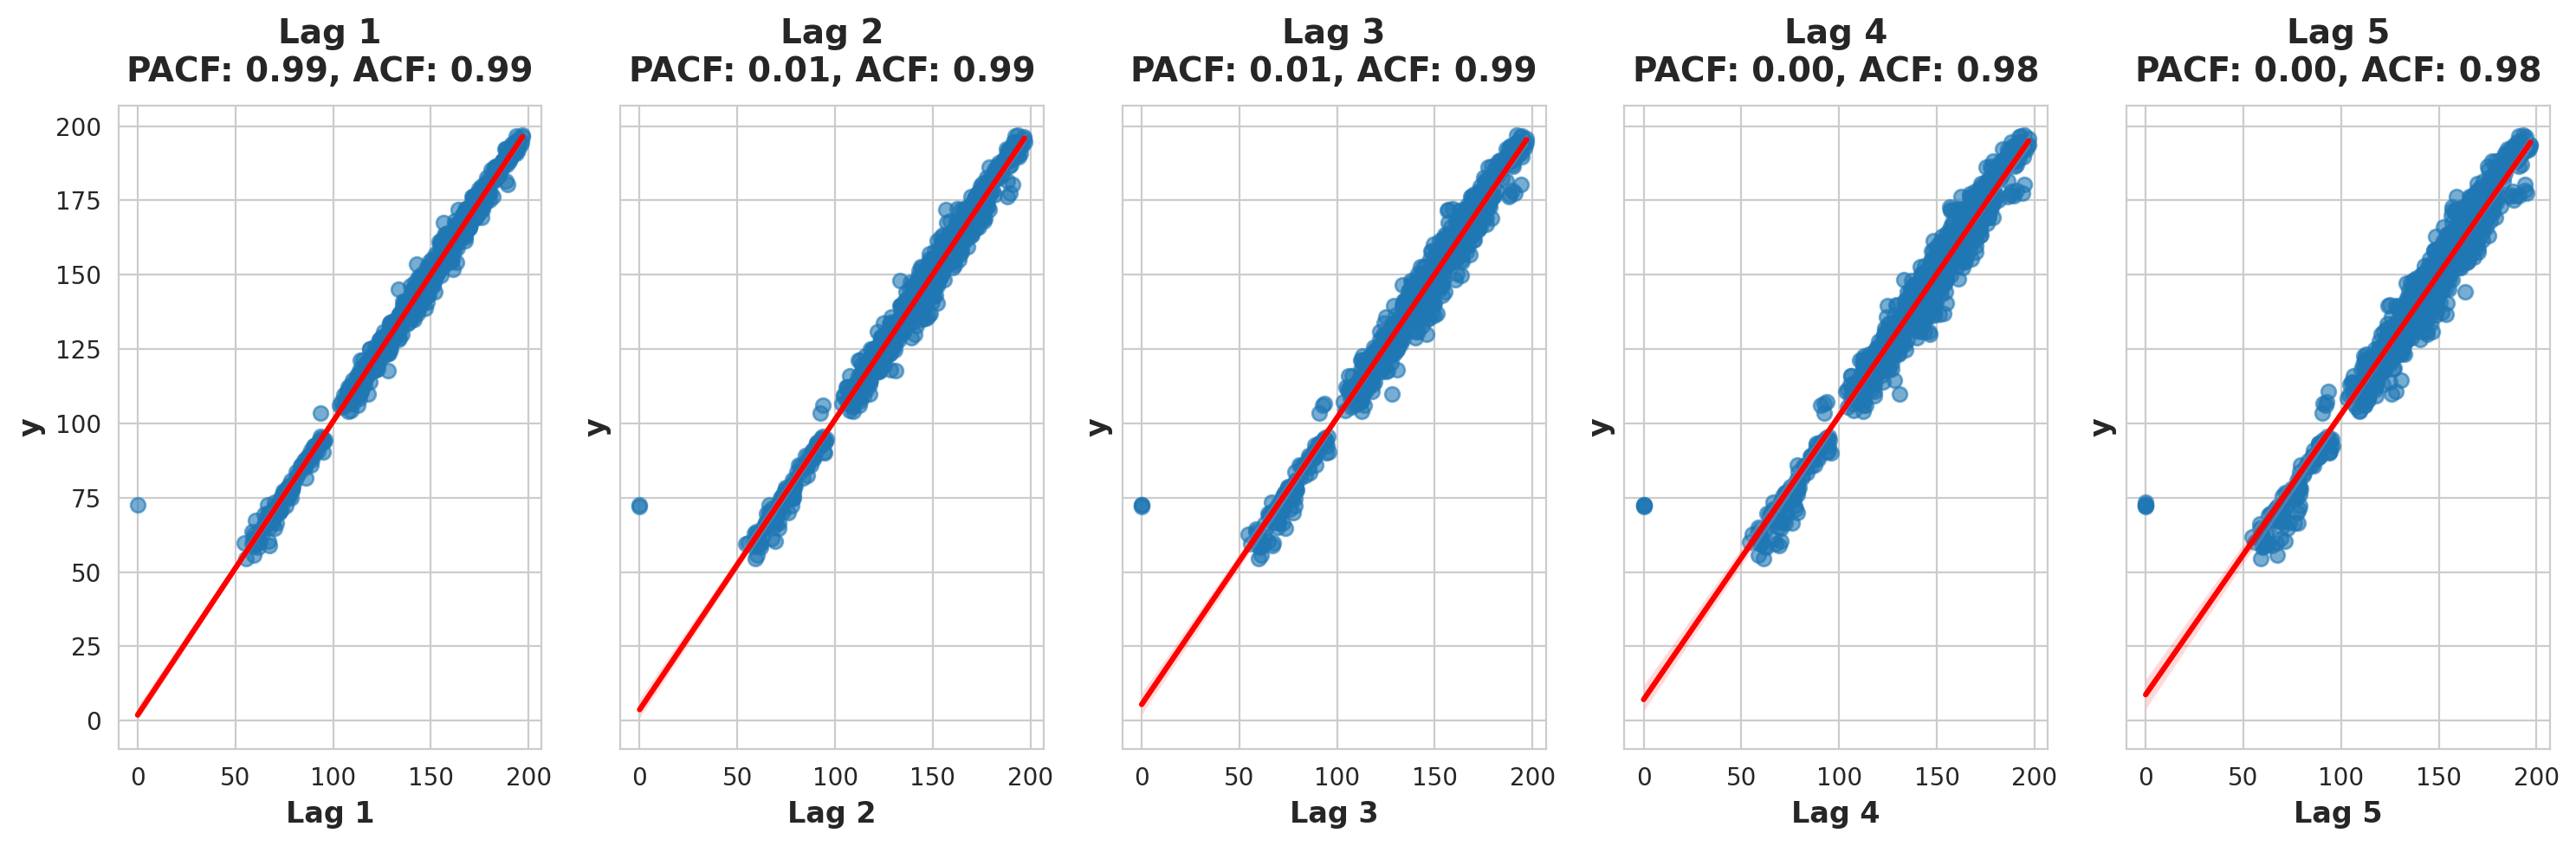

In [6]:
# plot lags

from statsmodels.graphics.tsaplots import pacf

# Assuming `df` contains the original series `y` and its lagged features
# Calculate partial autocorrelation for all lags
num_lags = 5  # Number of lags
partial_autocorr = pacf(df['y'], nlags=num_lags, method='ywm')

# Create subplots for each lag
fig, axes = plt.subplots(1, num_lags, figsize=(15, 5), sharey=True)

for lag in range(1, num_lags + 1):
    ax = axes[lag - 1]
    
    # Scatter plot with regression line
    sns.regplot(
        x=f'y_lag_{lag}', 
        y='y', 
        data=df, 
        ax=ax, 
        scatter_kws={'alpha': 0.6}, 
        line_kws={'color': 'red'}
    )
    
    # Calculate correlation coefficient
    corr = df['y'].corr(df[f'y_lag_{lag}'])
    
    # Set title with PACF and correlation values
    pacf_value = partial_autocorr[lag]
    ax.set_title(f"Lag {lag}\nPACF: {pacf_value:.2f}, ACF: {corr:.2f}")
    
    # Set axis labels
    ax.set_xlabel(f"Lag {lag}")
    if lag == 1:  # Only label the y-axis for the first plot
        ax.set_ylabel("y")

# Adjust layout
plt.tight_layout()
plt.show()

Lag 1 seems to have significant effect (big positive PACF) but not the rest. Let's make a model that used the time dummy index as predictor (for the trend) and lag1 (to model serial dependence of $y_t$ on $y_{t-1}$).

The model will be trained including the lag_1 information from X_train. We want to make predictions on X_test which is later in time and for which we do not have lag_1 (appart from the 1st element). For this we can use the predicted values that come from the algorithm.

If we were to just simply run the model on X_test, then it would read the real lag_1 for which we have access in the example, but which we would not have in a real situation.

See the plots below for comparison.

[*********************100%***********************]  1 of 1 completed


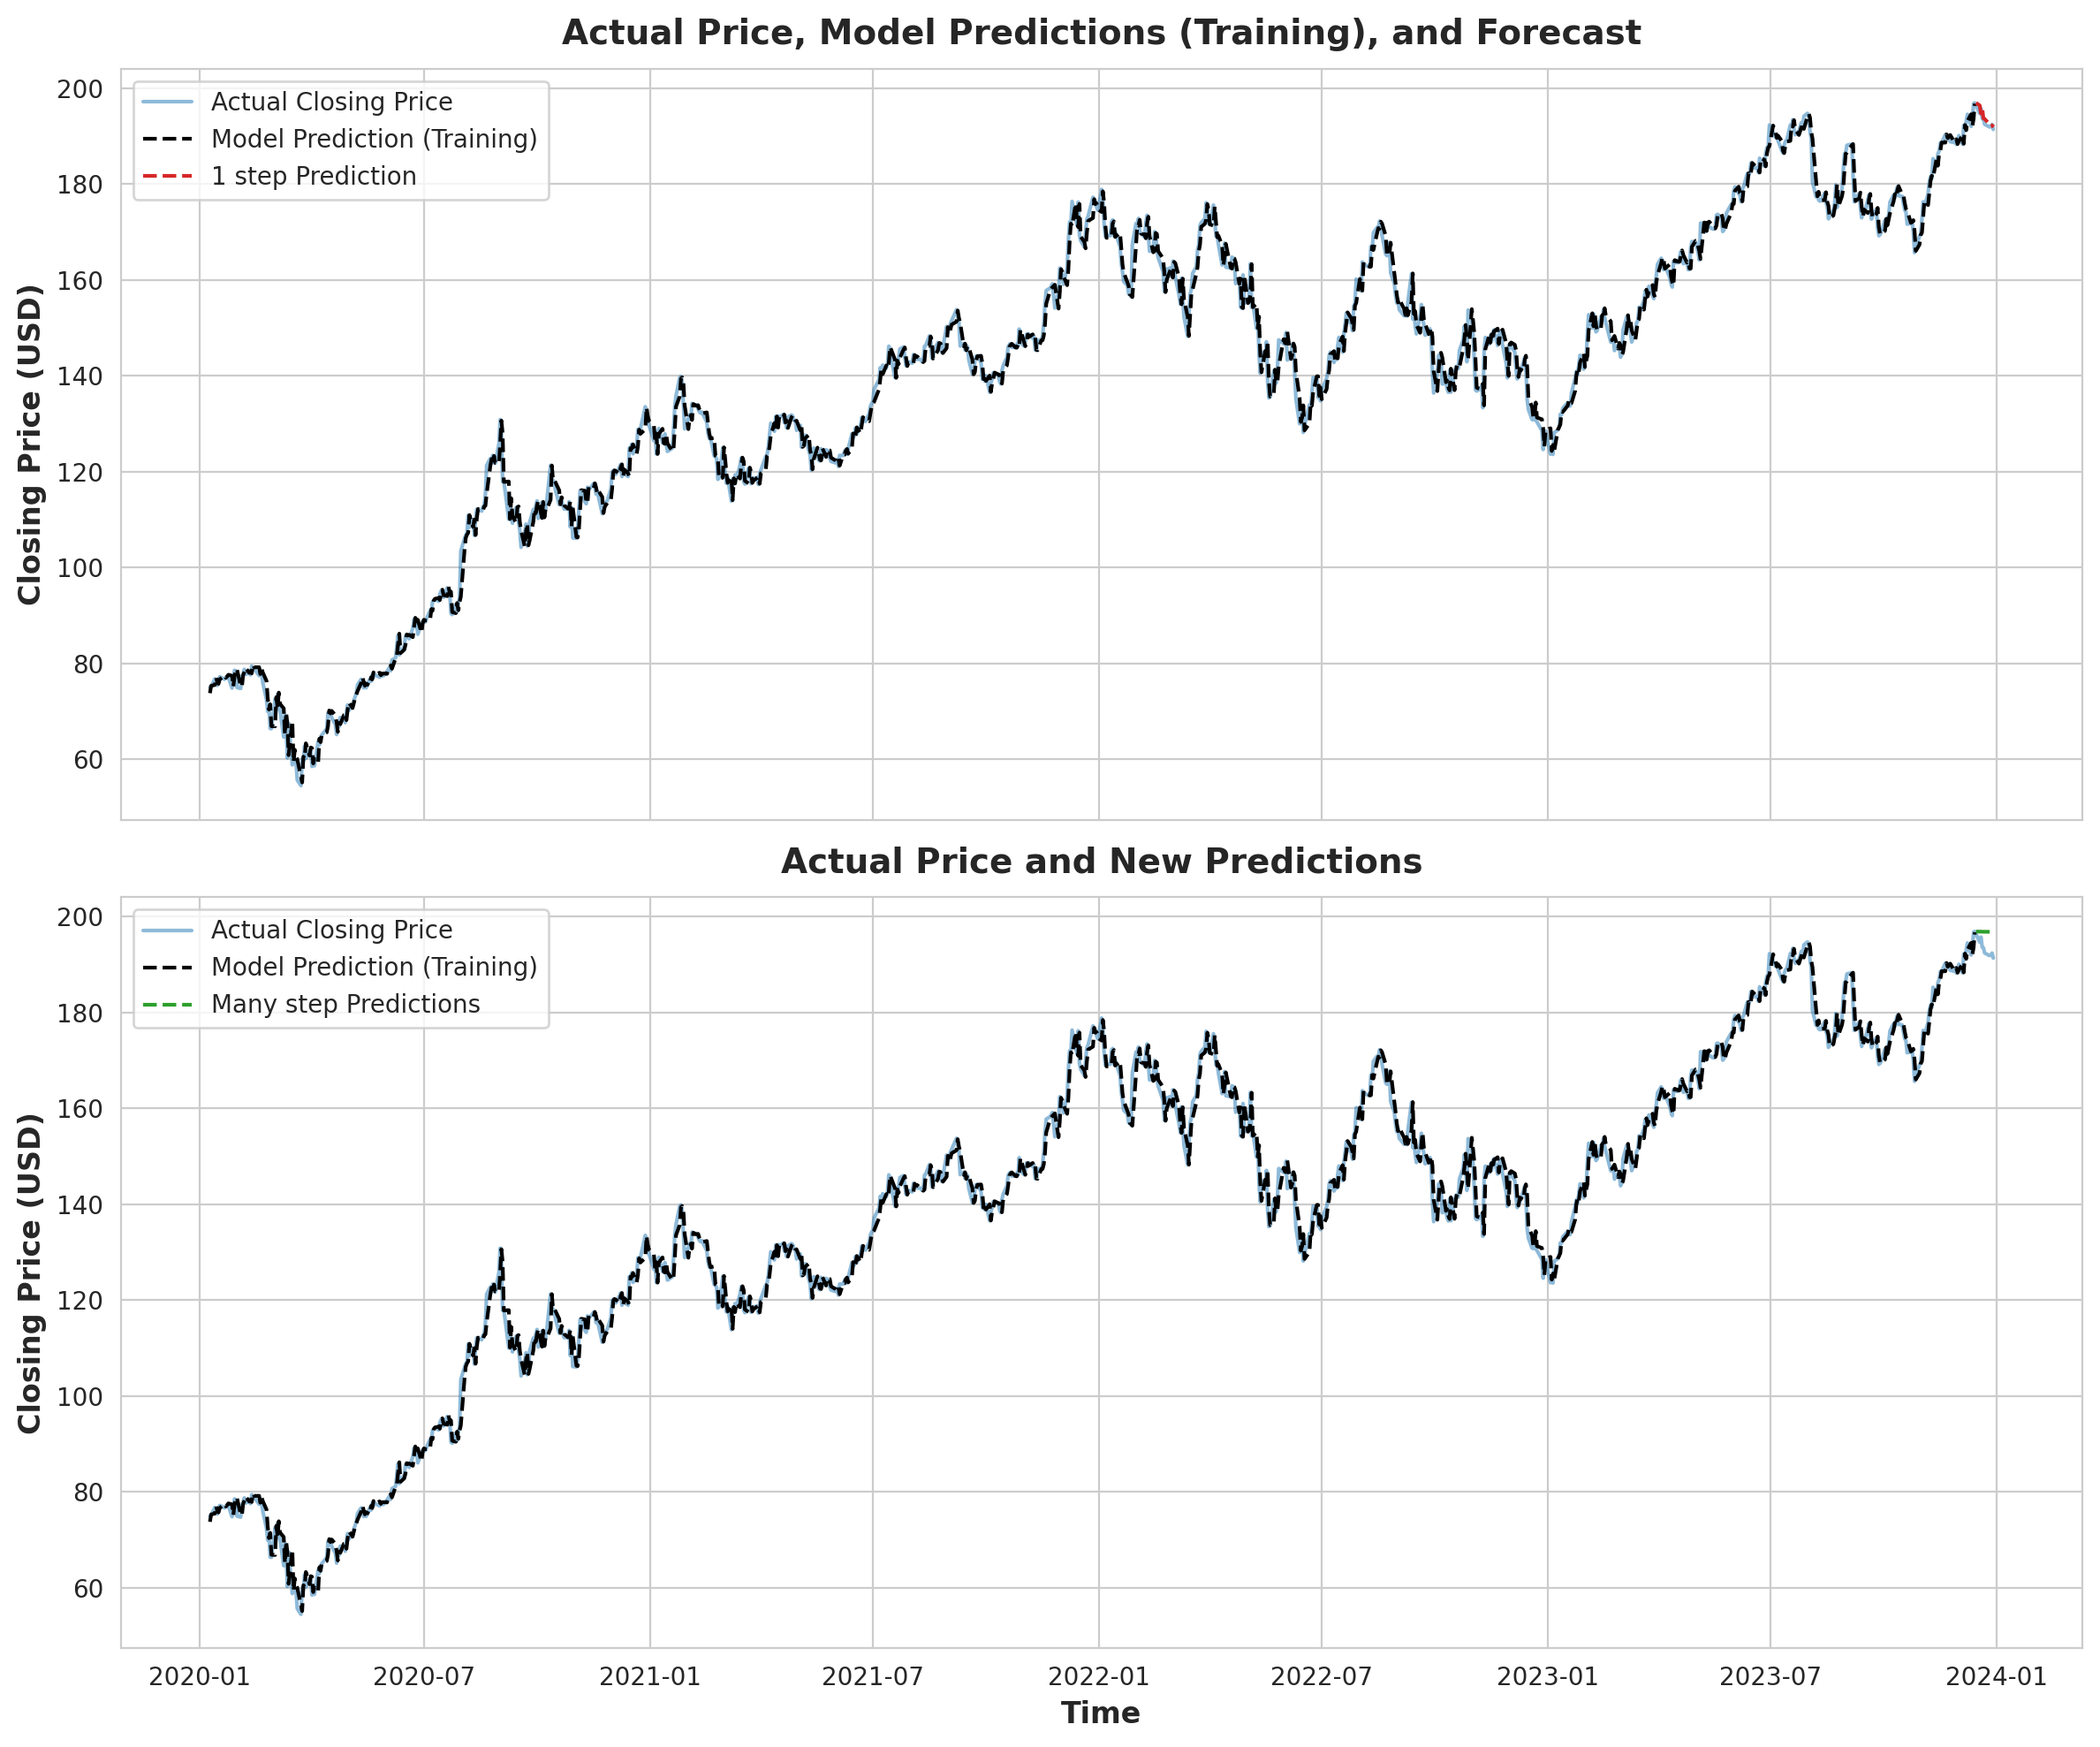

Model evaluation on the test set:
1 step predictions - Mean Squared Error (Test): 1.15
1 step predictions - Mean Absolute Error (Test): 0.87
many steps predictions - Mean Squared Error (Test): 14.56
many steps predictions - Mean Absolute Error (Test): 3.46


In [9]:
# reload the data (for safety)

# Fetch data
data = yf.download(ticker, start=start_date, end=end_date)

y = data['Close'].squeeze()  # Ensure y is a 1D Pandas Series

# Create a time dummy (labels for each time point)
time = np.arange(len(y))  # Create a sequence of integers for the time index

# Specify the number of lags
num_lags = 5  # Change this to the desired number of lags

# Create a DataFrame with time and y
df = pd.DataFrame({
    'time': time,  # Time feature
    'y': y         # Target (closing price)
})

# Dynamically create lagged features
for lag in range(1, num_lags + 1):
    df[f'y_lag_{lag}'] = df['y'].shift(lag)  # Create lagged columns

# Drop rows with NaN values (introduced by the lags)
df = df.dropna()#fillna(0.0)

# Create features and target
X = df[['time','y_lag_1']]  # Features (time dummy)
y = df['y']   # Target (closing price)
y, X = y.align(X, join='inner')

# Train-test split (80% train, 20% test, no shuffling to preserve time order)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define the number of test samples
num_test_samples = 10

# Split the data manually
X_train, X_test = X.iloc[:-num_test_samples], X.iloc[-num_test_samples:]
y_train, y_test = y.iloc[:-num_test_samples], y.iloc[-num_test_samples:]

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions simply by runnig the model on the test set
y_train_pred = pd.Series(model.predict(X_train), index=X_train.index)  # Predictions for training set
y_test_pred = pd.Series(model.predict(X_test), index=X_test.index)    # Predictions for testing set

# make predictions more realistaic by using the predictions as lag_1
# initiate an emtpy list to store predictions
new_pred_list = []
# Log lag_1 values during the test phase
lag_1_values = []
# Start with the last known value from the training set
lag_1 = y_train.iloc[-1]  

for i in range(len(X_test)):
    lag_1_values.append(lag_1)  # Log the current lag_1 value
    #print("y_lag_1 =", lag_1)
    # Update the lag_1 feature in the test set
    X_test.iloc[i, X_test.columns.get_loc('y_lag_1')] = lag_1
    # Predict the next value
    pred = model.predict(X_test.iloc[[i]])[0]
    # save prediction
    new_pred_list.append(pred)
    # Use the predicted value as the new lag_1
    lag_1 = pred
    # print("pred =",y_test_pred.iloc[i])
    # print("true =",y_test.iloc[i])
    # print()

# Assuming new_pred_list is already defined and aligned with X_test
new_pred_series = pd.Series(new_pred_list, index=X_test.index)  # Convert to Pandas Series with the same index

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)  # 2 rows, 1 column, shared x-axis

# First subplot: Original predictions
axes[0].plot(df.index, df['y'], label="Actual Closing Price", color="tab:blue", alpha=0.5)
axes[0].plot(X_train.index, y_train_pred, label="Model Prediction (Training)", color="black", linestyle="--")
axes[0].plot(X_test.index, y_test_pred, label="1 step Prediction", color="tab:red", linestyle="--")
axes[0].set_title("Actual Price, Model Predictions (Training), and Forecast")
axes[0].set_ylabel("Closing Price (USD)")
axes[0].legend()
axes[0].grid(True)

# Second subplot: New predictions
axes[1].plot(df.index, df['y'], label="Actual Closing Price", color="tab:blue", alpha=0.5)
axes[1].plot(X_train.index, y_train_pred, label="Model Prediction (Training)", color="black", linestyle="--")
axes[1].plot(X_test.index, new_pred_series, label="Many step Predictions", color="tab:green", linestyle="--")
axes[1].set_title("Actual Price and New Predictions")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Closing Price (USD)")
axes[1].legend()
axes[1].grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Evaluate the model on the test set for both predictions
print("Model evaluation on the test set:")
mse_original = mean_squared_error(y_test, y_test_pred)
mae_original = mean_absolute_error(y_test, y_test_pred)
print(f"1 step predictions - Mean Squared Error (Test): {mse_original:.2f}")
print(f"1 step predictions - Mean Absolute Error (Test): {mae_original:.2f}")

mse_new = mean_squared_error(y_test, new_pred_series)
mae_new = mean_absolute_error(y_test, new_pred_series)
print(f"many steps predictions - Mean Squared Error (Test): {mse_new:.2f}")
print(f"many steps predictions - Mean Absolute Error (Test): {mae_new:.2f}")

/home/thanasis/anaconda3/envs/market_forecasting_ml_py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/thanasis/anaconda3/envs/market_forecasting_ml_py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/thanasis/anaconda3/envs/market_forecasting_ml_py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/thanasis/anaconda3/envs/market_forecasting_ml_py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/thanasis/anaconda3/envs/market_for

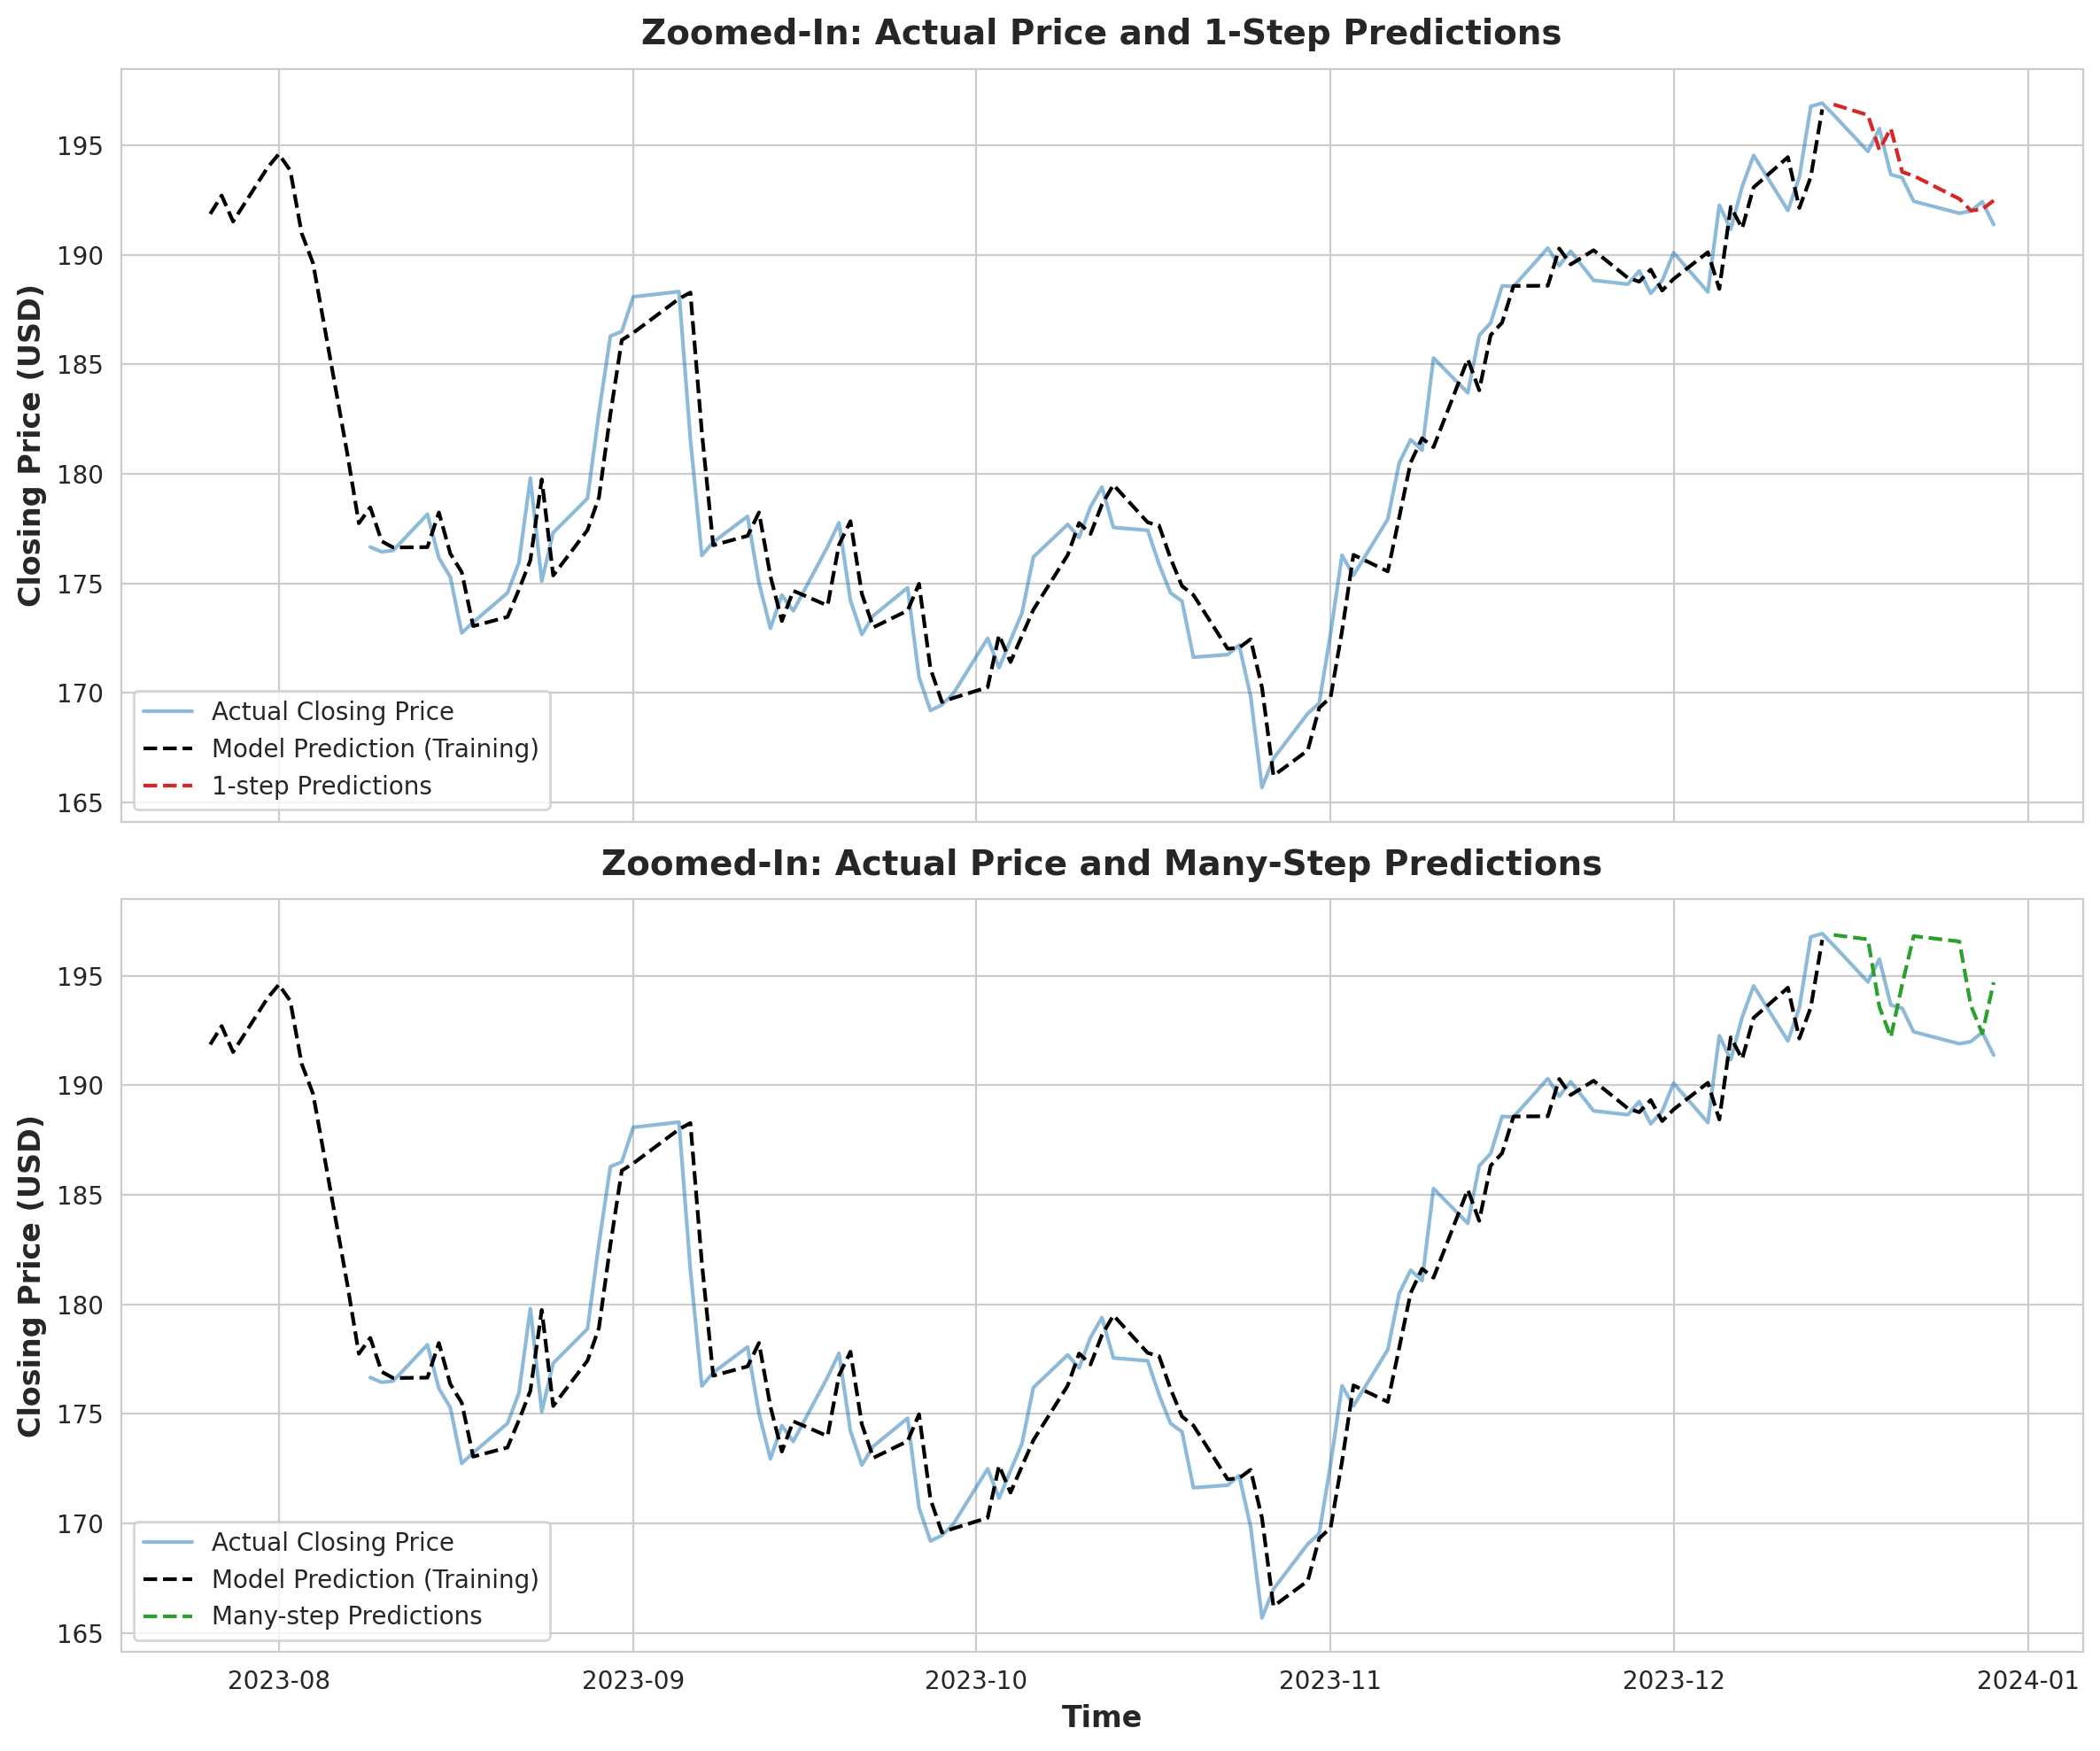

Model evaluation on the test set:
RMSE (Training): 2.63
1-step predictions - RMSE (Test): 1.07
Many-step predictions - RMSE (Test): 2.58


In [15]:
# Dynamically create lagged features
num_lags = 5  # Specify the number of lags
for lag in range(1, num_lags + 1):
    df[f'y_lag_{lag}'] = df['y'].shift(lag)  # Create lagged columns

# Drop rows with NaN values (introduced by the lags)
df = df.dropna()

# Create features and target
X = df[['time'] + [f'y_lag_{lag}' for lag in range(1, num_lags + 1)]]  # Features (time + lagged values)
y = df['y']  # Target (closing price)

# Align X and y to ensure no misalignment
y, X = y.align(X, join='inner')

# Train-test split (last 10 samples for testing)
num_test_samples = 10
X_train, X_test = X.iloc[:-num_test_samples], X.iloc[-num_test_samples:]
y_train, y_test = y.iloc[:-num_test_samples], y.iloc[-num_test_samples:]

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = pd.Series(model.predict(X_train), index=X_train.index)

# Make predictions on the test set (1-step predictions)
y_test_pred = pd.Series(model.predict(X_test), index=X_test.index)

# Make many-step predictions using rolling updates for lagged features
new_pred_list = []  # Store many-step predictions
lag_values = X_test.iloc[0, 1:].values  # Initialize with the last known lag values from the training set

for i in range(len(X_test)):
    # Update the lagged features dynamically
    X_test_row = np.concatenate(([X_test.iloc[i, 0]], lag_values))  # Combine time and lagged features
    pred = model.predict([X_test_row])[0]  # Predict the next value
    new_pred_list.append(pred)  # Store the prediction
    lag_values = np.roll(lag_values, -1)  # Shift lag values to the left
    lag_values[-1] = pred  # Add the new prediction as the most recent lag

# Convert the many-step predictions to a Pandas Series
new_pred_series = pd.Series(new_pred_list, index=X_test.index)

# Define zoom-in indices
zoom_start = -100  # Last 100 points
zoom_end = None    # Use None to include all points from zoom_start onward

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)  # 4 rows, 1 column, shared x-axis

# Third subplot: Zoomed-in view for 1-step predictions
axes[0].plot(df.index[zoom_start:zoom_end], df['y'][zoom_start:zoom_end], label="Actual Closing Price", color="tab:blue", alpha=0.5)
axes[0].plot(X_train.index[zoom_start:zoom_end], y_train_pred[zoom_start:zoom_end], label="Model Prediction (Training)", color="black", linestyle="--")
axes[0].plot(X_test.index[zoom_start:zoom_end], y_test_pred[zoom_start:zoom_end], label="1-step Predictions", color="tab:red", linestyle="--")
axes[0].set_title("Zoomed-In: Actual Price and 1-Step Predictions")
axes[0].set_ylabel("Closing Price (USD)")
axes[0].legend()
axes[0].grid(True)

# Fourth subplot: Zoomed-in view for many-step predictions
axes[1].plot(df.index[zoom_start:zoom_end], df['y'][zoom_start:zoom_end], label="Actual Closing Price", color="tab:blue", alpha=0.5)
axes[1].plot(X_train.index[zoom_start:zoom_end], y_train_pred[zoom_start:zoom_end], label="Model Prediction (Training)", color="black", linestyle="--")
axes[1].plot(X_test.index[zoom_start:zoom_end], new_pred_series[zoom_start:zoom_end], label="Many-step Predictions", color="tab:green", linestyle="--")
axes[1].set_title("Zoomed-In: Actual Price and Many-Step Predictions")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Closing Price (USD)")
axes[1].legend()
axes[1].grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Evaluate the model on the test set for both predictions
print("Model evaluation on the test set:")
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f"RMSE (Training): {rmse_train:.2f}")

rmse_1step = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"1-step predictions - RMSE (Test): {rmse_1step:.2f}")

rmse_rolling = np.sqrt(mean_squared_error(y_test, new_pred_series))
print(f"Many-step predictions - RMSE (Test): {rmse_rolling:.2f}")